# Proyecto 4 - Redes Neuronales Convolucionales 
## Machine Learning Models
## José Alejandro Guzmán Zamora 

In [1]:
# Framework con los algoritmos de ML necesarios 
import tensorflow as tf 
import keras

# Funciones necesarias para la arquitectura de la CNN 
from keras.utils import plot_model, to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

# Librerías para transformaciones y visualización de las imágenes 
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Función de división del dataset para cross validation 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Herramienta de serialización para guardar información que normalmente está en memoria
import pickle

# Matplotlib magic 
%matplotlib inline

# Verificación de uso de GPU por parte de Tensorflow 
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1



## Adaptación del Dataset
### Originalmente el dataset tiene una estructura por directorios, en las siguientes celdas se puede ver el proceso por medio del cual se recorre la misma y se construyen los arreglos de numpy correspondientes para trabajarlo. 

In [2]:
# Categorías 

"""
drawings - 0
engraving - 1 
iconography - 2 
painting - 3 
sculpture - 4 
"""

x = []
y = []

In [ ]:
# Recorrer los directorios y leer cada una de las imágenes, se ingresan a los arreglos x y

path = "../images/dataset/dataset_updated/training_set"
contador = 0

for filename in os.listdir(path):
    for filenameinterno in os.listdir(path + "/" + filename):
        x.append(cv.imread(path + "/" + filename + "/" + filenameinterno))
        y.append(contador)
    contador += 1


# Utilizar pickle para guardar los arreglos y no tener que correr la celda de nuevo

pickle.dump(np.asarray(x),open(r"D:\CS7\Machine Learning Models\artx.txt", "wb"))
pickle.dump(np.asarray(y),open(r"D:\CS7\Machine Learning Models\arty.txt", "wb"))

In [3]:
# Volver a utilizar pickle, pero ahorita para cargar la información 

pre_x = pickle.load(open(r"D:\CS7\Machine Learning Models\artx.txt", "rb"))
pre_y = pickle.load(open(r"D:\CS7\Machine Learning Models\arty.txt", "rb"))

print("Datos cargados, shape x - {} , shape y - {}".format(pre_x.shape, pre_y.shape))

Datos cargados, shape x - (8685,) , shape y - (8685,)


## Exploración y Transformaciones Iniciales

In [4]:
# Recorrer los arreglos para obtener información de nulos y tamaño de imágenes 
    
shapes = [(i.shape[0] * i.shape[1]) for i in pre_x if i is not None]

info = """Información Importante\n
Cantidad de datos nulos: {}
Mayor cantidad de píxeles: {}
Menor cantidad de píxeles: {}
Cantidad de píxeles promedio: {}
""".format(pre_x.shape[0] - len(shapes),
          max(shapes),
          min(shapes),
          np.mean(np.array(shapes)))

print(info)

Información Importante

Cantidad de datos nulos: 108
Mayor cantidad de píxeles: 3048192
Menor cantidad de píxeles: 11840
Cantidad de píxeles promedio: 145104.13466246938



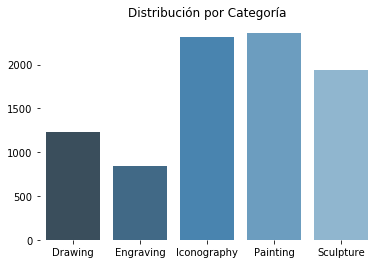

In [5]:
# Verificar la cantidad de imágenes disponibles por categoría 

categories = ["Drawing","Engraving","Iconography","Painting","Sculpture"]

counts = np.unique(pre_y, return_counts=True)
ax = sns.barplot(x=categories, y=counts[1], palette="Blues_d")
plt.title("Distribución por Categoría")
sns.despine(left=True,bottom=True)
plt.show()

# Se puede ver que hay un claro desbalance, específicamente con las clases de Drawing y Engraving 

In [6]:
def clean_size(x,y,size):
    """
    Eliminar datos nulos y cambiar dimensión de la imagen. 
    
    Args:
        x (np.ndarray): arreglo con las imágenes a modificar
        y (np.ndarray): arreglo con los labels de cada imagen
        size (int): valor del tamaño deseado para imagen cuadrada 
    Returns:
        tuple(np.ndarray,np.ndarray): valores finales de x y 
    """
    el = []
    for i in range(len(x)):
        if x[i] is None:
            el.append(i)
            continue
        else:
            x[i] = cv.resize(x[i],(size,size))
            x[i] = cv.cvtColor(x[i],cv.COLOR_BGR2RGB)
    x = np.array(list(np.delete(x,el)))
    y = np.delete(y,el)
    print("New shape of Dataset: ",x.shape)
    return (x,y)
    
# valores a continuar utilizando, imágenes de (64,64,3)
sig_data = clean_size(pre_x,pre_y,64)
sig_x = sig_data[0]
sig_y = sig_data[1]

New shape of Dataset:  (8577, 64, 64, 3)


In [7]:
# Se determinó que las primeras dos clases son lo suficientemente similares para
# hacer la unión de las mismas y resolver el desbalance 

new_y = np.array([1 if i == 0 else i for i in sig_y]) - 1

counts_new = np.unique(new_y, return_counts=True)
counts_new

(array([0, 1, 2, 3]), array([2070, 2308, 2270, 1929], dtype=int64))

In [8]:
# Copia en caso de que se tenga que hacer algún cambio después 
final_y = new_y.copy()
final_x = sig_x.copy()

print("Shape total de x: ",final_x.shape)
print("Shape total de y: ", final_y.shape)

# Estas shapes ya están listas para ingresar a cualquier modelo

Shape total de x:  (8577, 64, 64, 3)
Shape total de y:  (8577,)


In [9]:
# División para cross validation


x_train,x_test,y_train,y_test = train_test_split(final_x,final_y,test_size=0.2,random_state=2)

## Arquitecturas y Entrenamientos de Prueba
### Antes de llegar al modelo utilizado se utilizaron distintas arquitecturas de prueba

In [10]:
def basic_evaluation(x,y,model,history,show):
    """
    Evaluación básica del modelo y proceso de entrenamiento.
    
    Args:
        x (np.ndarray): arreglo con imágenes de validación 
        y (np.ndarray): arreglo con los labels de las imágenes
        model (Sequential): modelo sequencial de Keras 
        history (History): historia del entrenamiento en Keras 
        show (boolean): show accuracy
    Returns:
        Loss & Accuracy: display de valores 
        Visualization: visualización de la historia de entrenamiento
    """
    if show:
        print("Rendimiento General: ")
        score, acc = model.evaluate(x,y,batch_size=64)
        print('Test Loss:', score)
        print('Test accuracy:', acc)

    plt.plot(history.history['accuracy'], label='Train Accuracy', color="blue")
    plt.plot(history.history['val_accuracy'], label = 'Train Validation Accuracy')
    plt.plot(history.history['loss'], label = 'Loss', color="purple")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.2, 1])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    plt.title("Historia del Entrenamiento")
    plt.box(False)
    plt.show()

In [11]:
primero_history = pickle.load(open('./models/test1_test.txt','rb'))
primero_modelo = load_model('./models/test1.h5')
primero_modelo.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [12]:
print("PRIMER MODELO A EVALUAR\n")
print(primero_modelo.summary())

PRIMER MODELO A EVALUAR

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)          

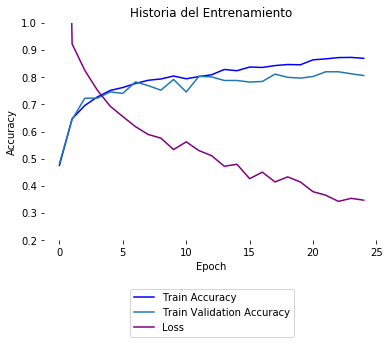

In [13]:
basic_evaluation(x_test,y_test,primero_modelo,primero_history,False)

# Tuvo buen aprendizaje pero en poca cantidad de epochs empezó a overfittearse 
# El acurracy estuvo por debajo de 80%

In [14]:
segundo_history = pickle.load(open('./models/test3_test.txt','rb'))
segundo_modelo = load_model('./models/test3.h5')
segundo_modelo.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print("SEGUNDO MODELO A EVALUAR\n")
print(segundo_modelo.summary())

SEGUNDO MODELO A EVALUAR

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)         

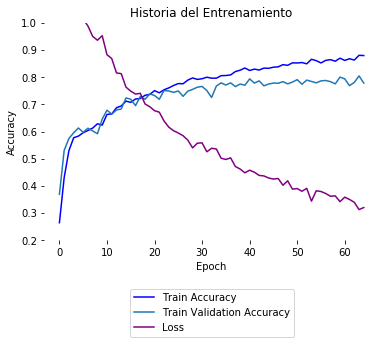

In [15]:
basic_evaluation(x_test,y_test,segundo_modelo,segundo_history,False)

# Este modelo utiliza menos capas densas, el entrenamiento se ve ligeramente más alborotado
# El accuracy también está debajo de 80% se desea mejorar este valor y el grado de overfitting es mayor

In [18]:
tercero_history = pickle.load(open('./models/main1.txt','rb'))
tercero_modelo = load_model('./models/main1.h5')
tercero_modelo.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
print("TERCER MODELO A EVALUAR\n")
print(tercero_modelo.summary())

TERCER MODELO A EVALUAR

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          

Rendimiento General: 
1716/1716 [==============================] - 2s 1ms/step
Test Loss: 0.5158520927240243
Test accuracy: 0.8368298411369324


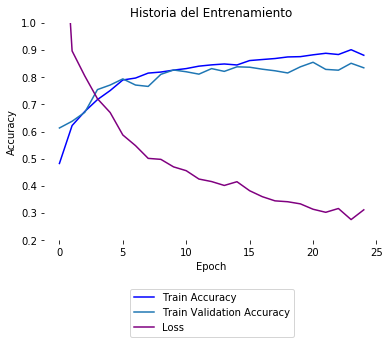

In [19]:
basic_evaluation(x_test,y_test,tercero_modelo,tercero_history,True)

# Este modelo ya utiliza la estructura final con 5 convoluciones y 2 capas densas 
# La diferencia es que en este modelo la cantidad de filtros va en orden descendiente
# Accuracy mayor, con 84 %

## Modelo a Utilizar
### A continuación se presenta la arquitectura final utilizada para el resto del análisis

In [20]:
# Cargar el modelo

modeloh = pickle.load(open('./models/main2.txt','rb'))
modelo = load_model('./models/main2.h5')
modelo.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
print("MODELO \n")
print(modelo.summary())

# Se puede verificar que contiene 5 capas convolucionales con cantidad de filtros ascendiente
# El grado de dropout es mayor para las capas densas 
# Hay 2 capas densas de 512 y 256 neuronas respectivamente

MODELO 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 13, 13, 6

In [21]:
code = """
CODIGO UTILIZADO, POR MOTIVOS ILUSTRATIVOS PORQUE SE CARGÓ DE MEMORIA


main2 = Sequential()

main2.add(Conv2D(32, (3,3), activation='relu', input_shape=(x_train.shape[1:])))
main2.add(MaxPooling2D(pool_size=(2,2)))
main2.add(Dropout(0.25))

main2.add(Conv2D(64, (3,3), activation='relu'))
main2.add(Conv2D(64, (3,3), activation='relu'))
main2.add(MaxPooling2D(pool_size=(2,2)))
main2.add(Dropout(0.25))

main2.add(Conv2D(128, (3,3), activation='relu'))
main2.add(Conv2D(128, (3,3), activation='relu'))
main2.add(MaxPooling2D(pool_size=(2,2)))
main2.add(Dropout(0.25))

main2.add(Flatten())
main2.add(Dense(512,activation='relu'))
main2.add(Dropout(0.3))
main2.add(Dense(256,activation='relu'))
main2.add(Dense(4,activation='softmax'))

main2.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print(main2.summary())
"""

Rendimiento General: 
1716/1716 [==============================] - 1s 339us/step
Test Loss: 0.45528260040116475
Test accuracy: 0.86771559715271


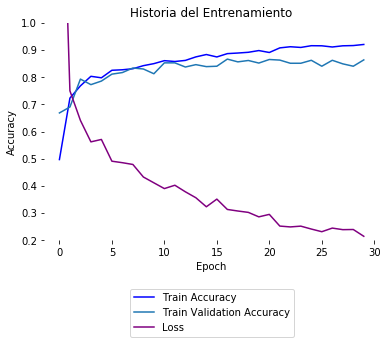

In [22]:
basic_evaluation(x_test,y_test,modelo,modeloh,True)

# En este modelo hay ligeramente menos overfitting pero empieza a aumentar después de la epoch 20 
# Este tiene el mejor rendimiento en base a accuracy con 87%

In [23]:
# Evaluación en base a matriz de confusión 

y_pred = modelo.predict(x_test)
y_pred_use = np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))])

# Utilización de función de sklearn para desplegar los resultados 
matriz = confusion_matrix(y_test,y_pred_use)
matriz_percent = np.round((matriz / matriz.sum()) * 100,2)

print("Matriz de Confusión Original: \n   0    1    2    3\n",matriz)

print("\n\nMatriz de Confusión Porcentual: \n    0      1      2      3\n",matriz_percent)
print("\n\nKey:\n0-Drawings\n1-Iconography\n2-Painting\n3-Sculpture")

# En general se puede verificar que el rendimiento es correcto, hay un poco de problema para la clase de drawing

Matriz de Confusión Original: 
   0    1    2    3
 [[323  28  26  40]
 [ 13 427  15   5]
 [ 14  18 394  18]
 [ 32  11   7 345]]


Matriz de Confusión Porcentual: 
    0      1      2      3
 [[18.82  1.63  1.52  2.33]
 [ 0.76 24.88  0.87  0.29]
 [ 0.82  1.05 22.96  1.05]
 [ 1.86  0.64  0.41 20.1 ]]


Key:
0-Drawings
1-Iconography
2-Painting
3-Sculpture


## Análisis de Feature Maps

In [24]:
def plot_features(model,layer,img):
    """
    Mostrar todos los feature maps de output de una capa específica.
    
    Args:
        model (Sequential): Modelo secuencial de Keras para extraer la capa
        layer (int): índice de la capa convolucional 
        img (np.ndarray): imagen sobre la que se aplican los filtros 
    Results:
        Visualización: total de features se muestran 
        result: arreglo con todos los feature maps
    """
    conv = Model(inputs=model.inputs, outputs=model.layers[layer].output)
    result = conv.predict(img)
    number = result.shape[3]
    cant = number / 8
    fig = plt.figure(figsize=(20,(cant/4) * 10))
    for i in range(number):
        ax = fig.add_subplot(cant,8,i+1)
        ax.imshow(result[0,:,:,i],cmap='gray',aspect='auto')
        ax.axis('off')
    plt.show()
    return result

def previous_transform(path):
    """
    Preparar imagen individual para el modelo. 
    
    Args:
        path(String): path hacia la imagen a transformar
    Returns:
        image(np.ndarray): imagen transformada 
    """
    prueba_drawing = cv.cvtColor(cv.imread(path),cv.COLOR_BGR2RGB)
    plt.imshow(prueba_drawing)
    plt.axis("off")
    print("Imagen a Transformar y Utilizar:\n")
    plt.show()
    return np.expand_dims(cv.resize(prueba_drawing,(64,64)),0)

def return_class(img,model):
    """
    Clasificar Imagen.
    
    Args:
        img (np.ndarray): imagen a clasificar 
        model (Sequential): modelo entrenado a utilizar 
    Returns:
        Clasificación
    
    """
    types = ['Drawing/Engraving','Iconography','Painting','Sculpture']
    print("Clasificado como: ",types[np.argmax(model.predict(img))])
    
    
def plot_interesting(arreglo,results):
    fig = plt.figure(figsize=(10,10))
    cont = 1
    for i in arreglo:
        ax = fig.add_subplot(2,2,cont)
        ax.imshow(results[0,:,:,i],cmap='gray',aspect='auto')
        ax.axis("off")
        cont += 1
    plt.show()

## Feature Maps para Painting

Imagen a Transformar y Utilizar:



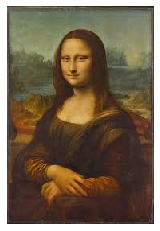

Clasificado como:  Painting


In [25]:
img1 = previous_transform('./tests/painting1.jpg')
return_class(img1,modelo)

### Primera Convolución
### 32 Feature Maps

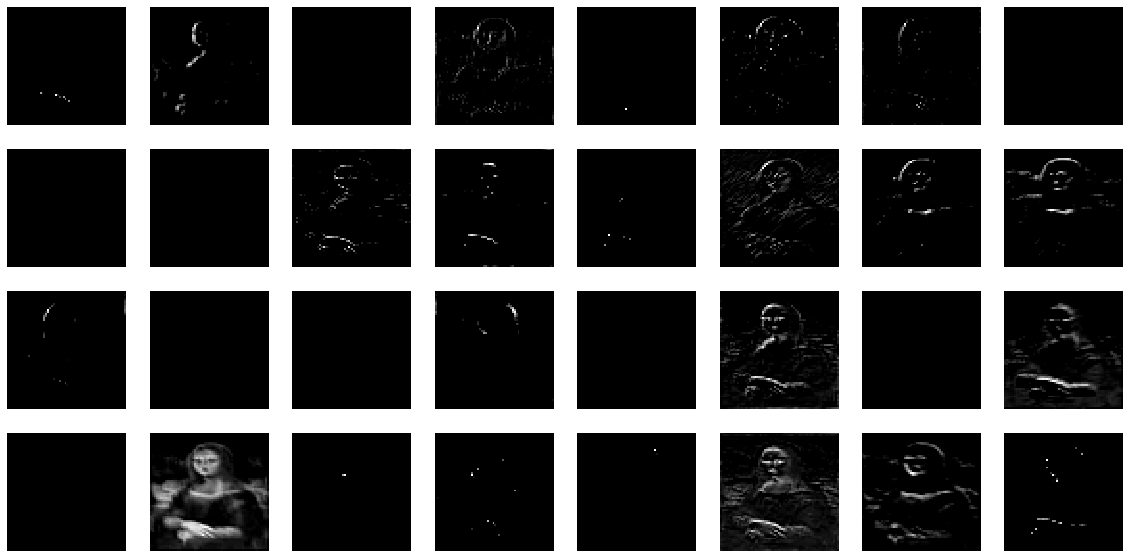

In [26]:
res0 = plot_features(modelo,0,img1)

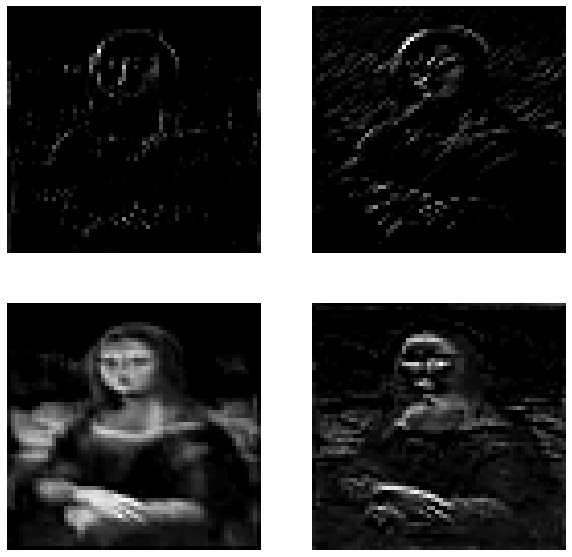

In [27]:
# Los 4 feature maps más interesantes, detección de líneas horizontales y verticales 
# También hay cierta detección de superficies y profundidad 

interesantes = [3,13,25,29]
plot_interesting(interesantes,res0)

### Segunda Convolución 
### 64 Feature Maps

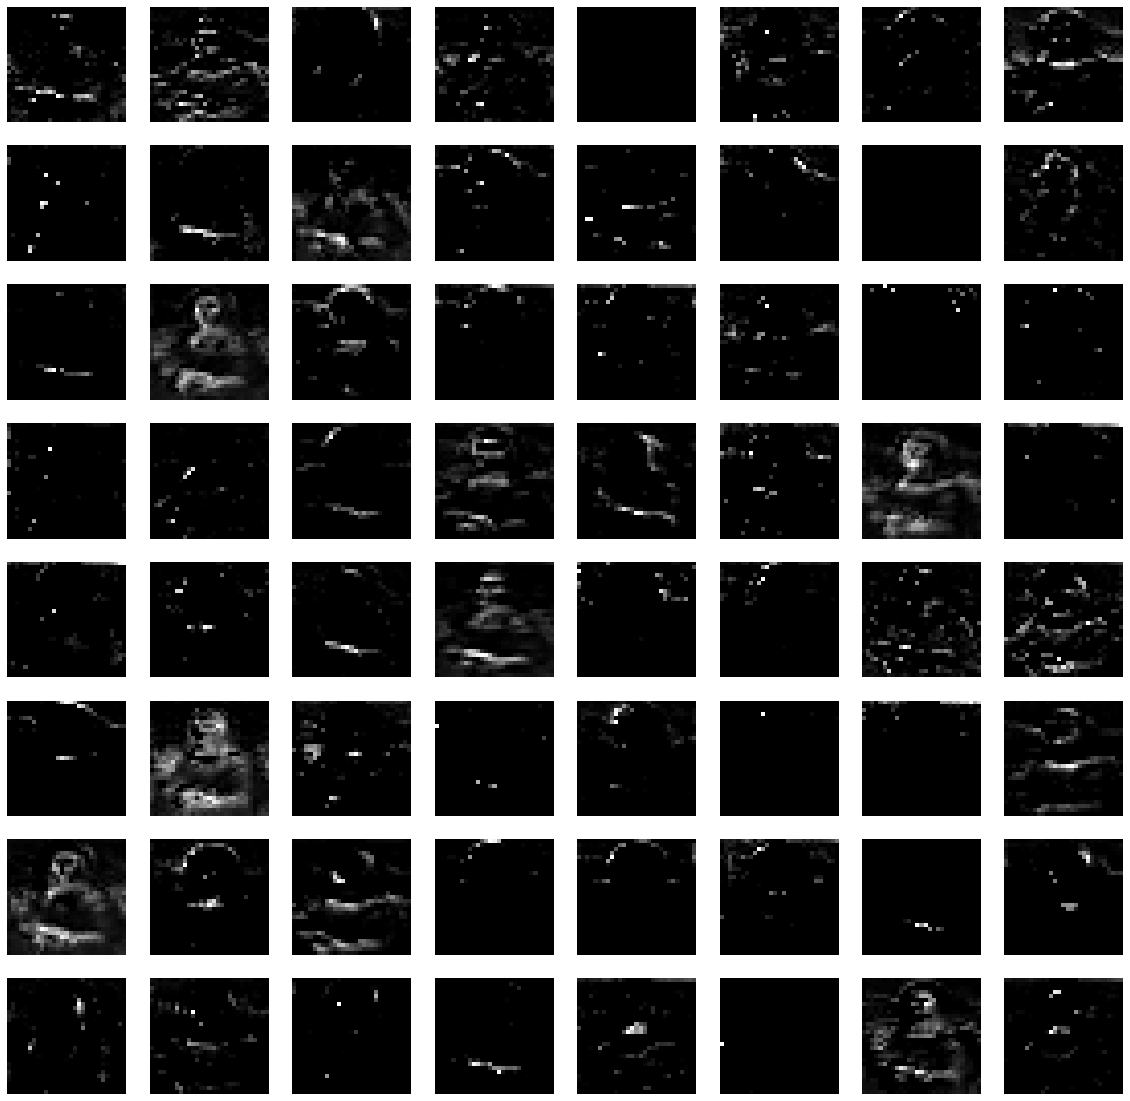

In [28]:
res3 = plot_features(modelo,3,img1)

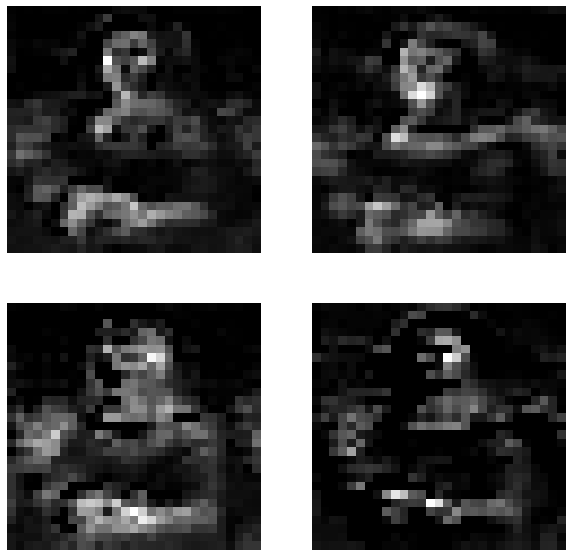

In [29]:
# Pareciera que hay un enfoque en la cara y en los ojos, se resaltan en varios feature maps 
# El tercero desfigura la pintura parece que está identificando a la persona en general

interesantes = [17,30,41,62]
plot_interesting(interesantes,res3)

### Cuarta Convolución 
### 128 Feature Maps

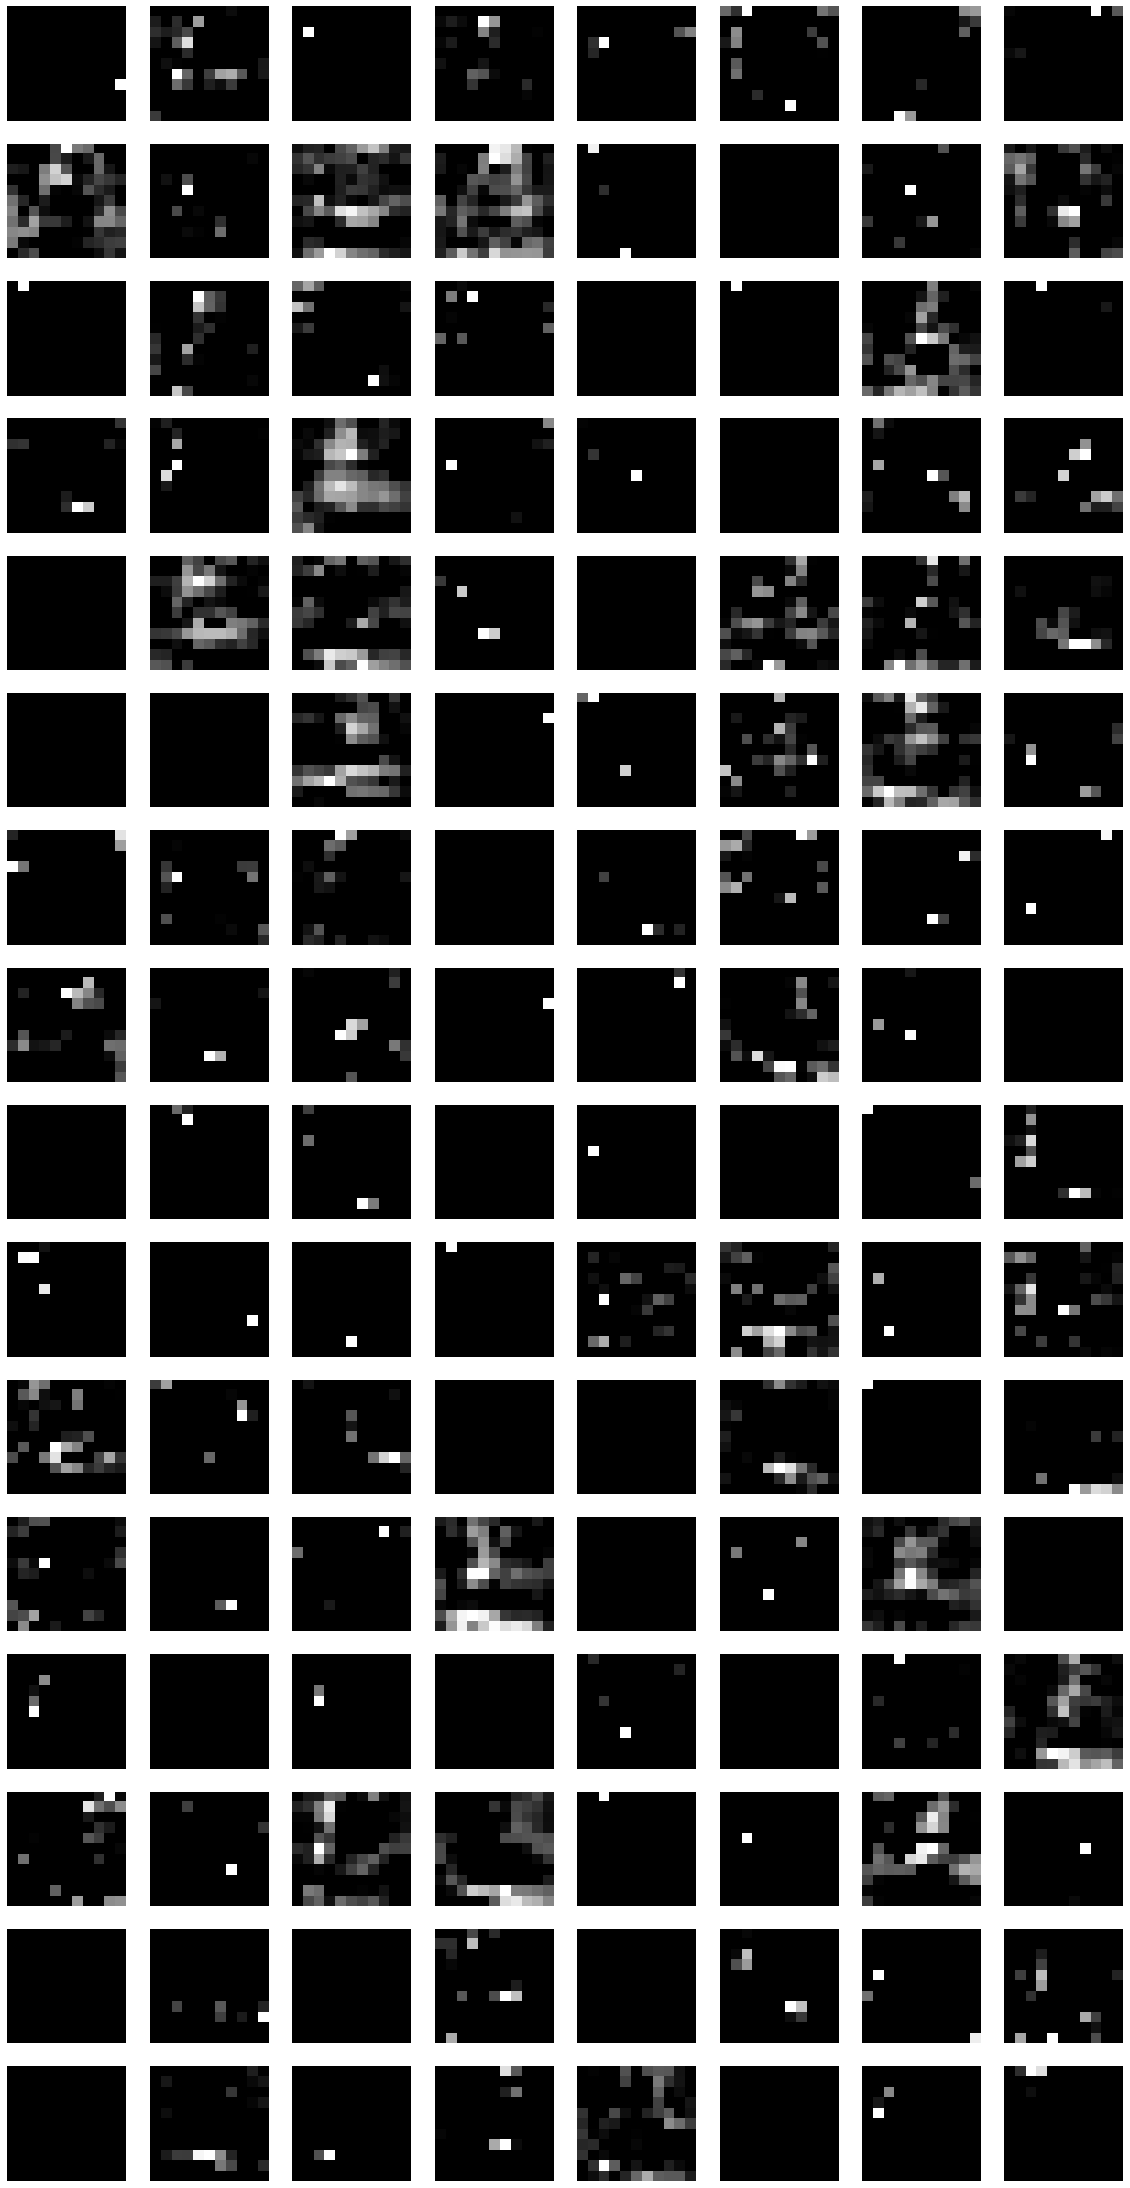

In [30]:
res7 = plot_features(modelo,7,img1)

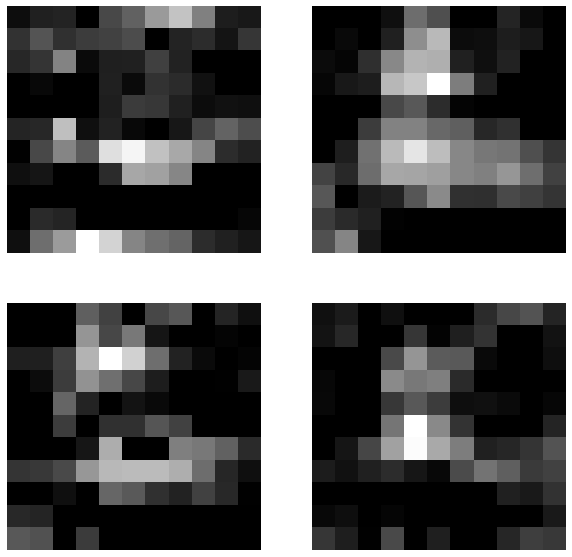

In [31]:
# Características más específicas

interesantes = [10,26,33,94]
plot_interesting(interesantes,res7)

## Feature Maps para Drawing

Imagen a Transformar y Utilizar:



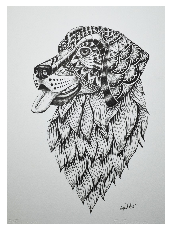

Clasificado como:  Drawing/Engraving


In [32]:
img2 = previous_transform('./tests/drawing1.jpg')
return_class(img2,modelo)

### Primera Convolución 
### 32 Feature Maps

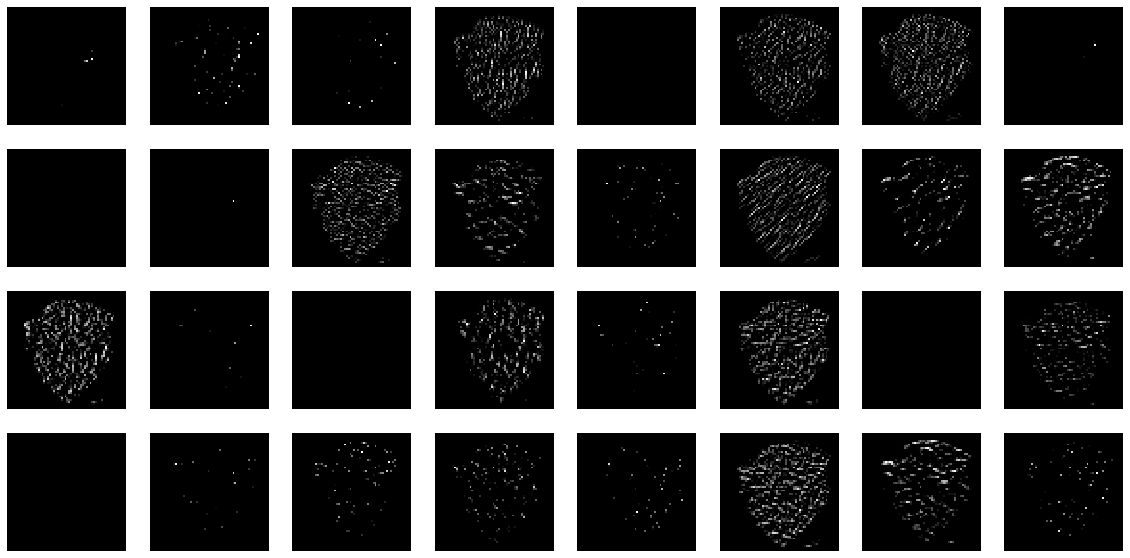

In [33]:
res11 = plot_features(modelo,0,img2)

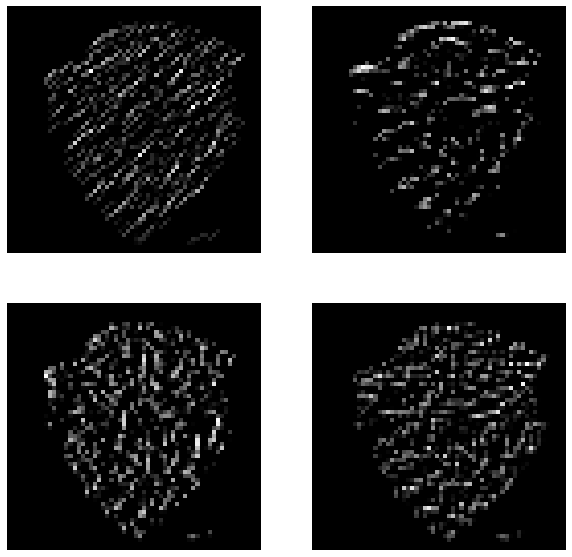

In [34]:
# Todo tipo de detección general, líneas horizontales, verticales, diseños específicos

interesantes = [13,15,16,21]
plot_interesting(interesantes,res11)

### Segunda Convolución 
### 64 Feature Maps

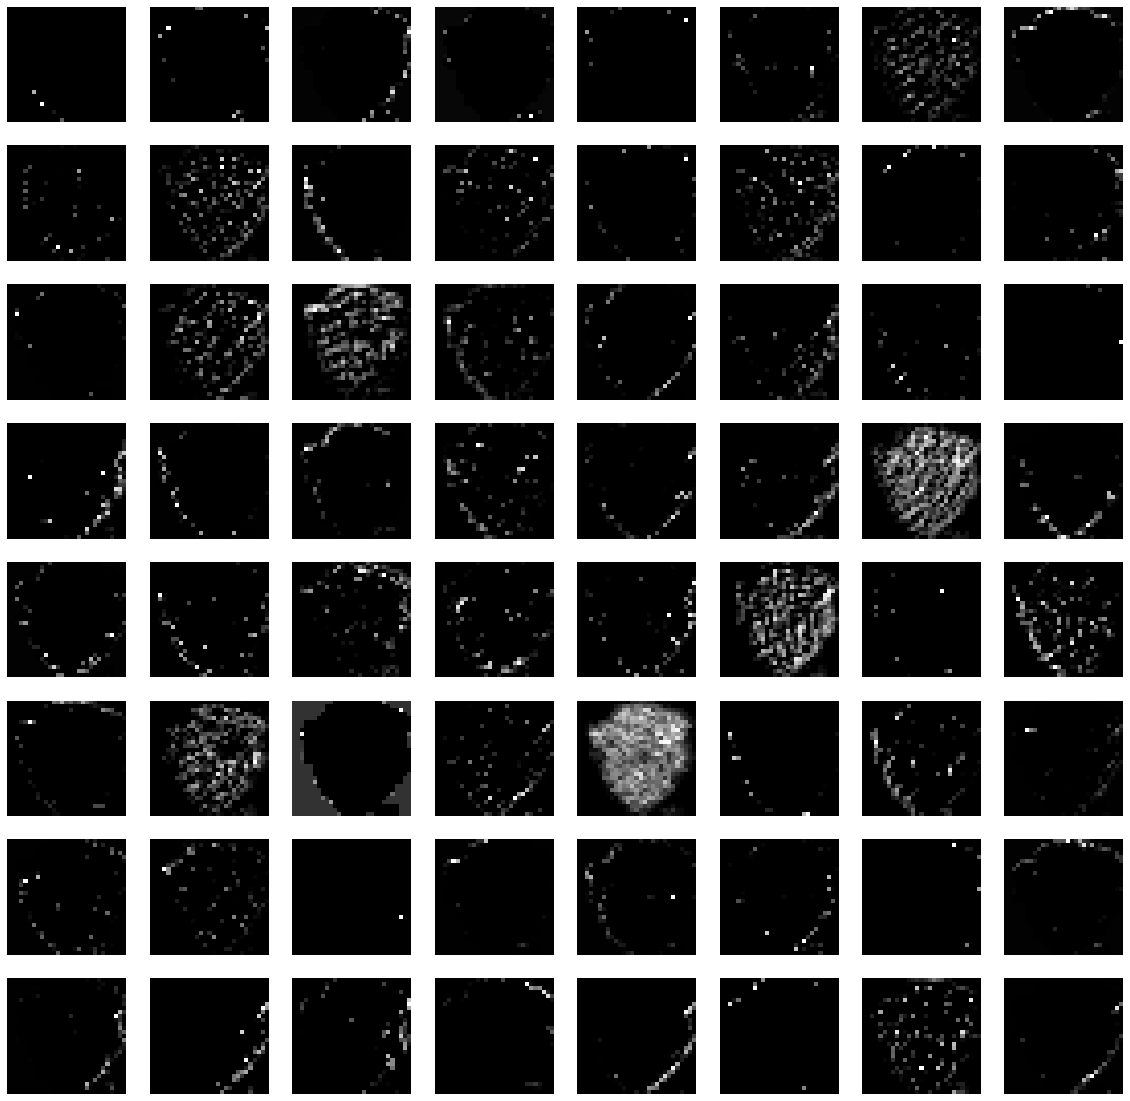

In [35]:
res21 = plot_features(modelo,3,img2)

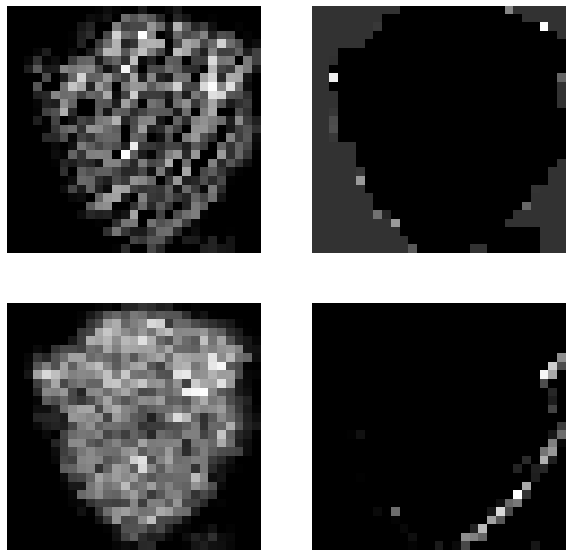

In [36]:
# Enfoque en la figura principal
# Clara detección del fondo uniforme que representa la hoja en blanco
# Detección de ciertos bordes

plot_interesting([30,42,44,60],res21)

### Cuarta Convolución 
### 128 Feature Maps 

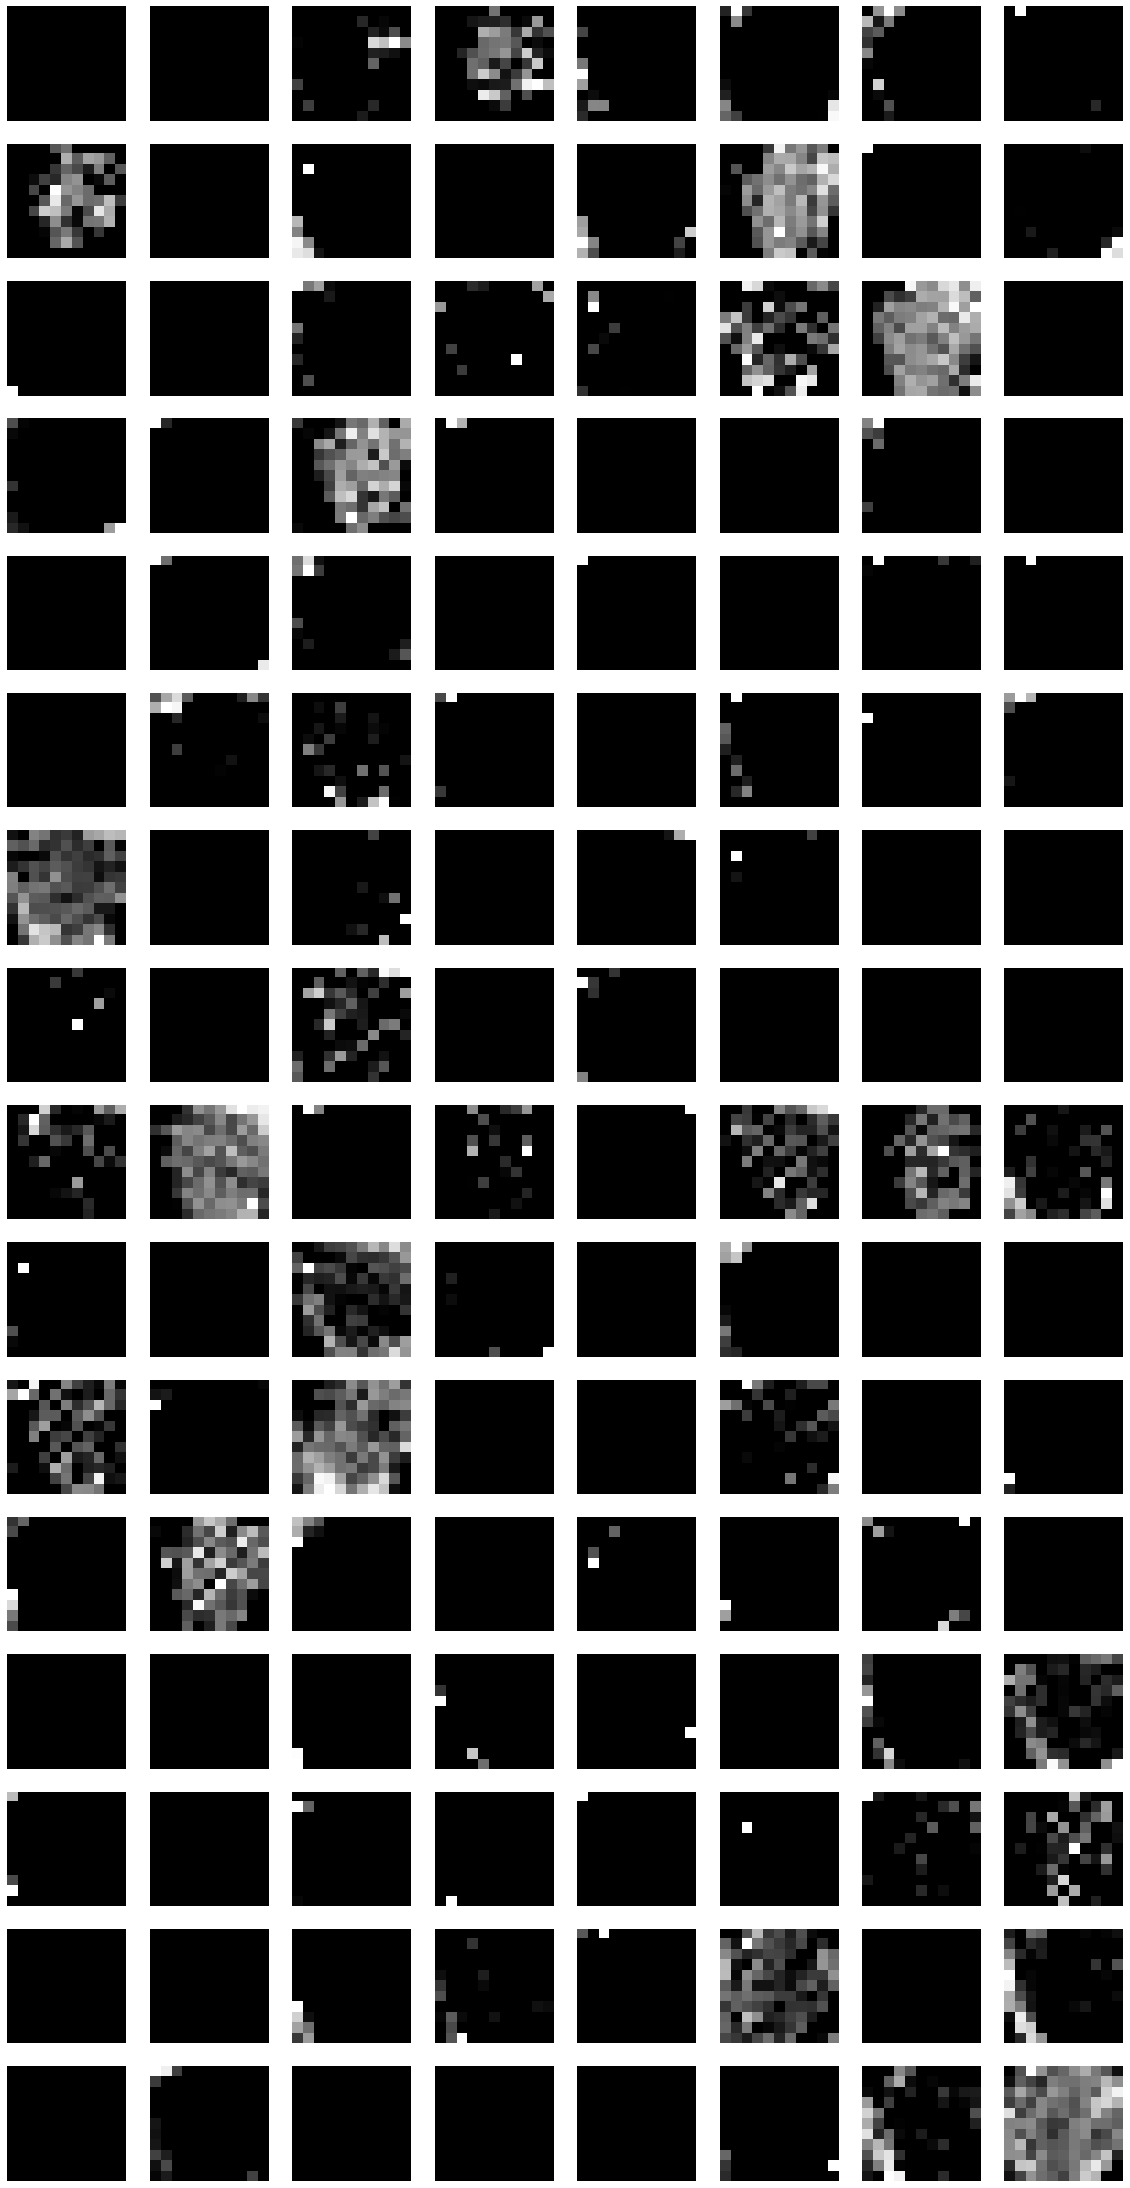

In [37]:
res31 = plot_features(modelo,7,img2)

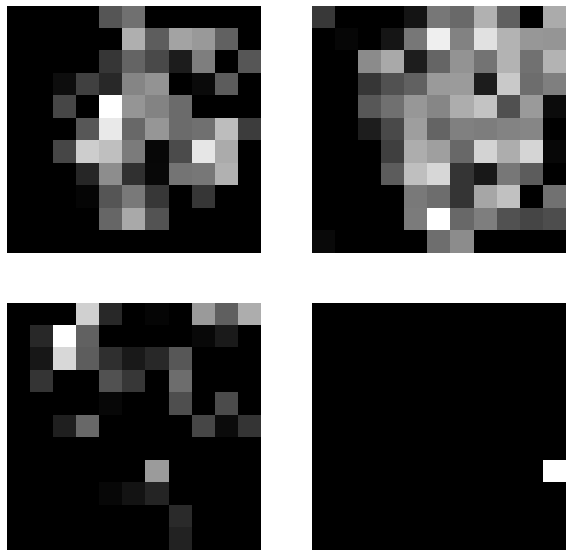

In [38]:
plot_interesting([8,26,64,100],res31)

## Feature Maps para Iconography

Imagen a Transformar y Utilizar:



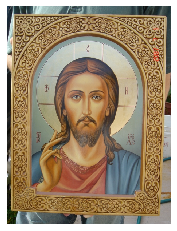

Clasificado como:  Iconography


In [39]:
img3 = previous_transform('./tests/iconography1.jpg')
return_class(img3,modelo)

### Primera Convolución 
### 32 Feature Maps

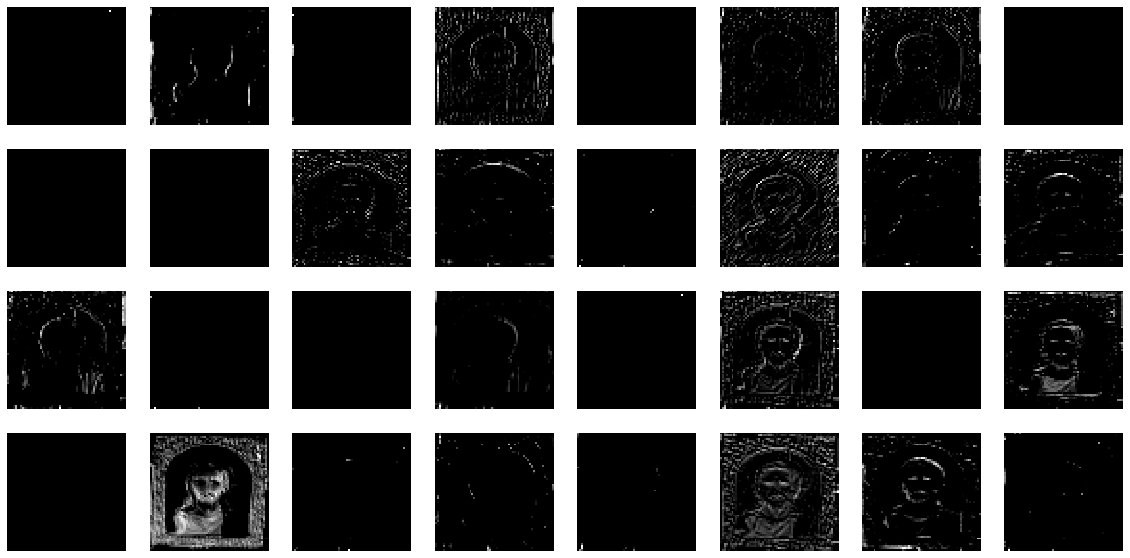

In [40]:
res21 = plot_features(modelo,0,img3)

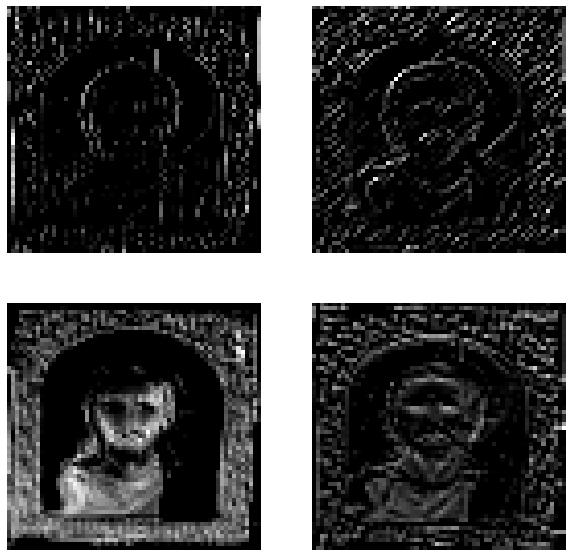

In [41]:
# De igual manera se puede ver la detección de líneas en diferentes direcciones
# Diferenciación entre el marco de la imagen y la figura central 
# Profundidad

plot_interesting([3,13,25,29],res21)

### Segunda Convolución 
### 64 Feature Maps

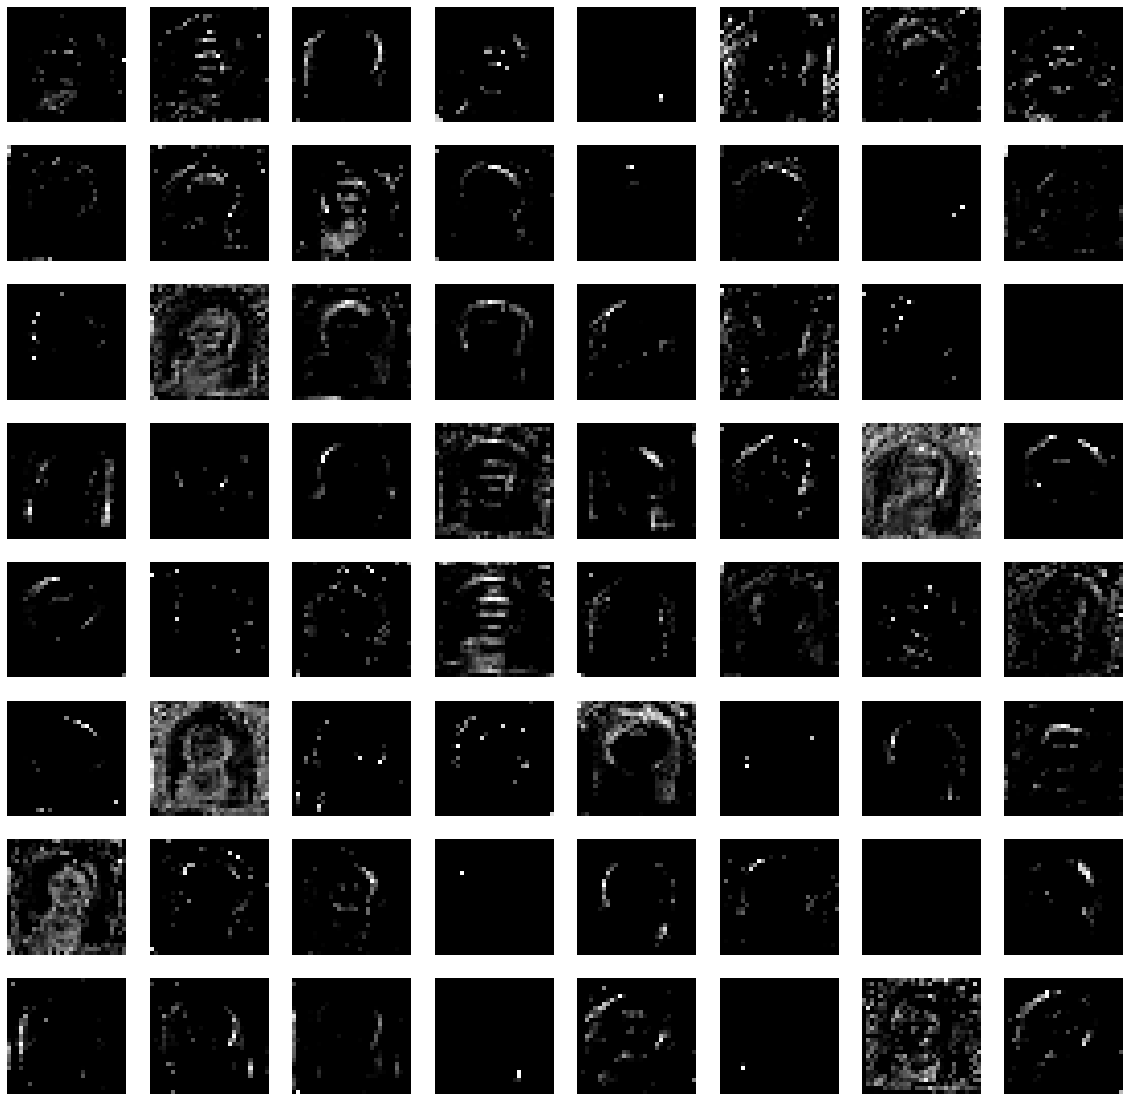

In [42]:
res22 = plot_features(modelo,3,img3)

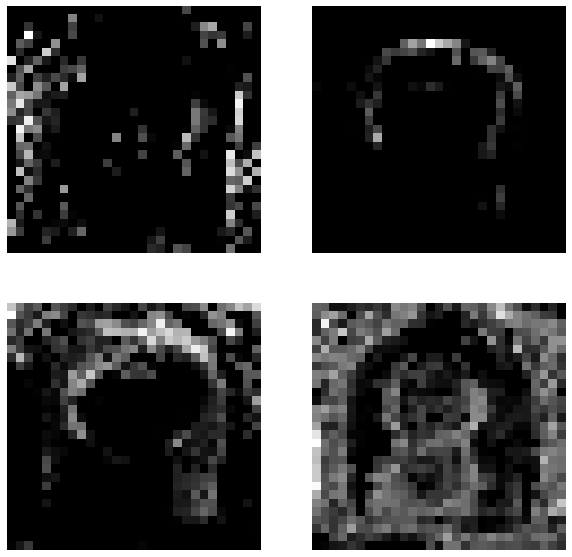

In [43]:
# Detalles específicos del marco de alrededor
# Empieza a identificar la figura circular que rodea al ente central

plot_interesting([5,19,44,41],res22)

### Cuarta Convolución 
### 128 Feature Maps 

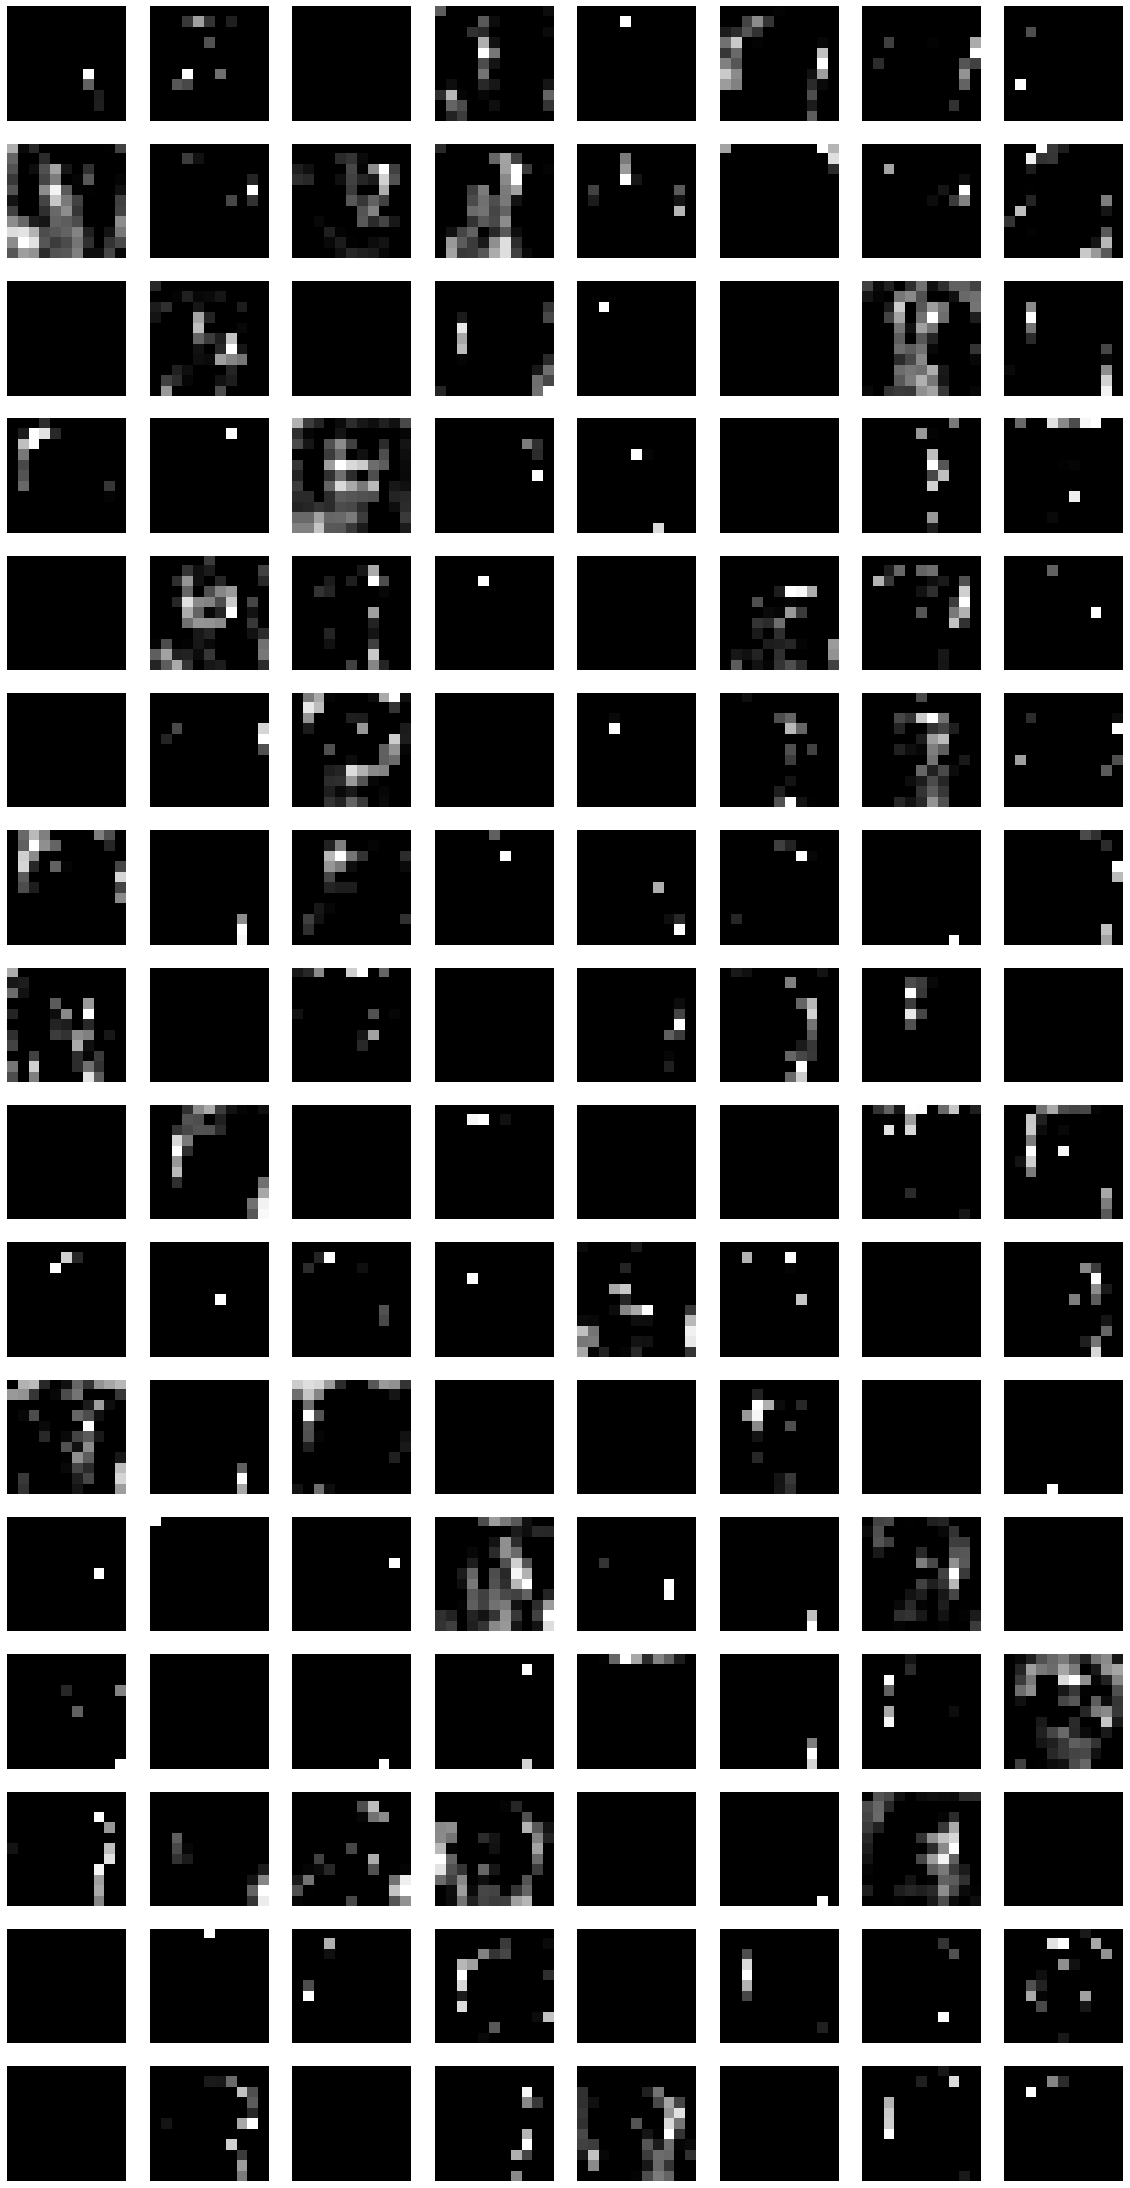

In [44]:
res23 = plot_features(modelo,7,img3)

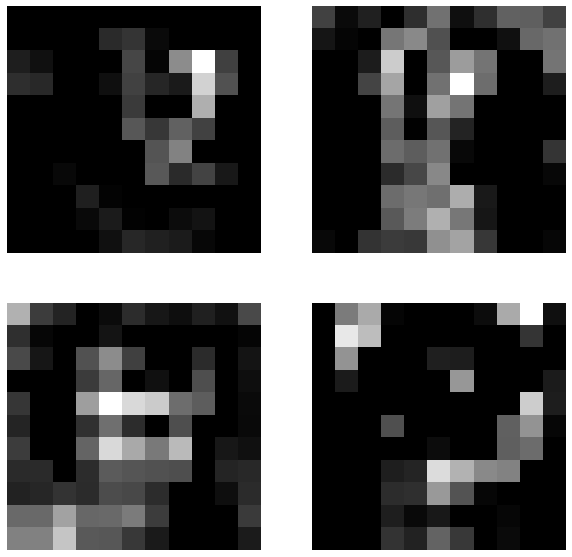

In [45]:
# Enfoque en la figura central 
# Aspectos de la cara como los ojos 

plot_interesting([10,22,26,42],res23)

## Feature Maps para Sculpture

Imagen a Transformar y Utilizar:



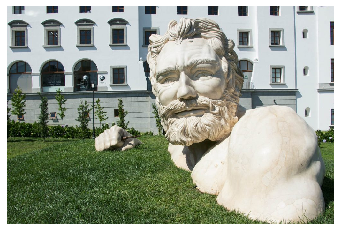

Clasificado como:  Sculpture


In [46]:
img4 = previous_transform('./tests/sculpture1.jpg')
return_class(img4,modelo)

### Primera Convolución 
### 32 Feature Maps

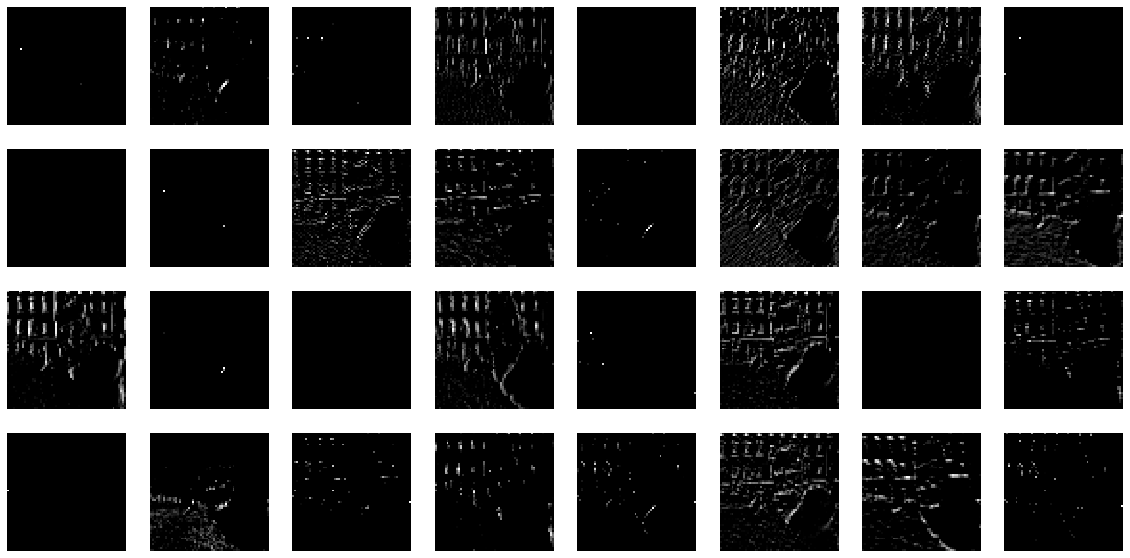

In [47]:
res31 = plot_features(modelo,0,img4)

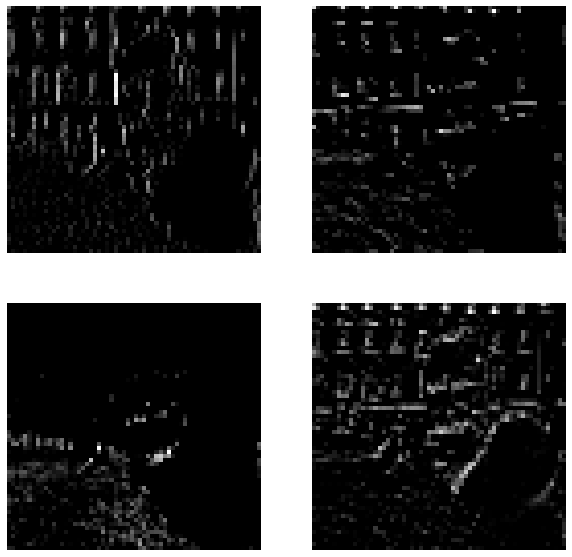

In [48]:
# Líneas verticales, líneas horizontales
# Detalles del fondo en conjunto con los de la cara
# Un poco de detección de la grama

plot_interesting([3,11,25,29],res31)

### Segunda Convolución 
### 64 Feature Maps 

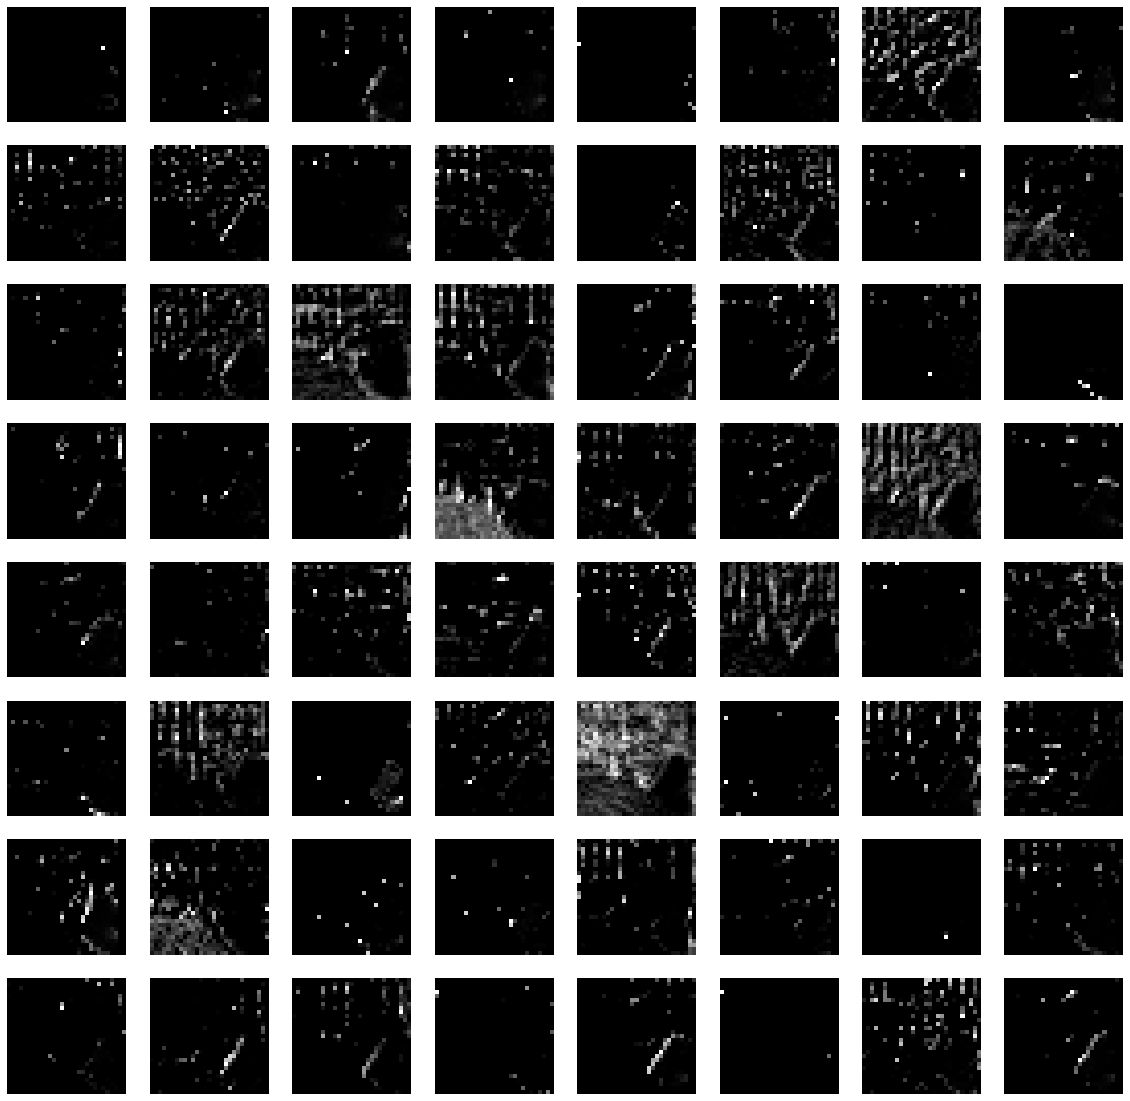

In [49]:
res32 = plot_features(modelo,3,img4)

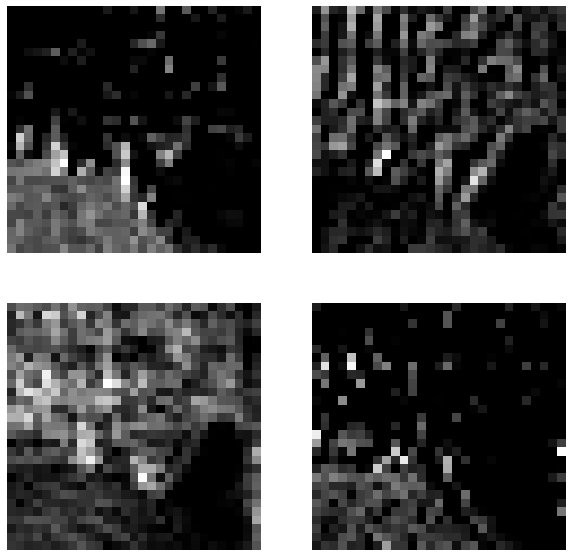

In [50]:
# Separación clara de la grama a lo demás 
# Enfoque en los detalles del edificio de atrás 

plot_interesting([27,30,44,49],res32)

### Cuarta Convolución 
### 128 Feature Maps

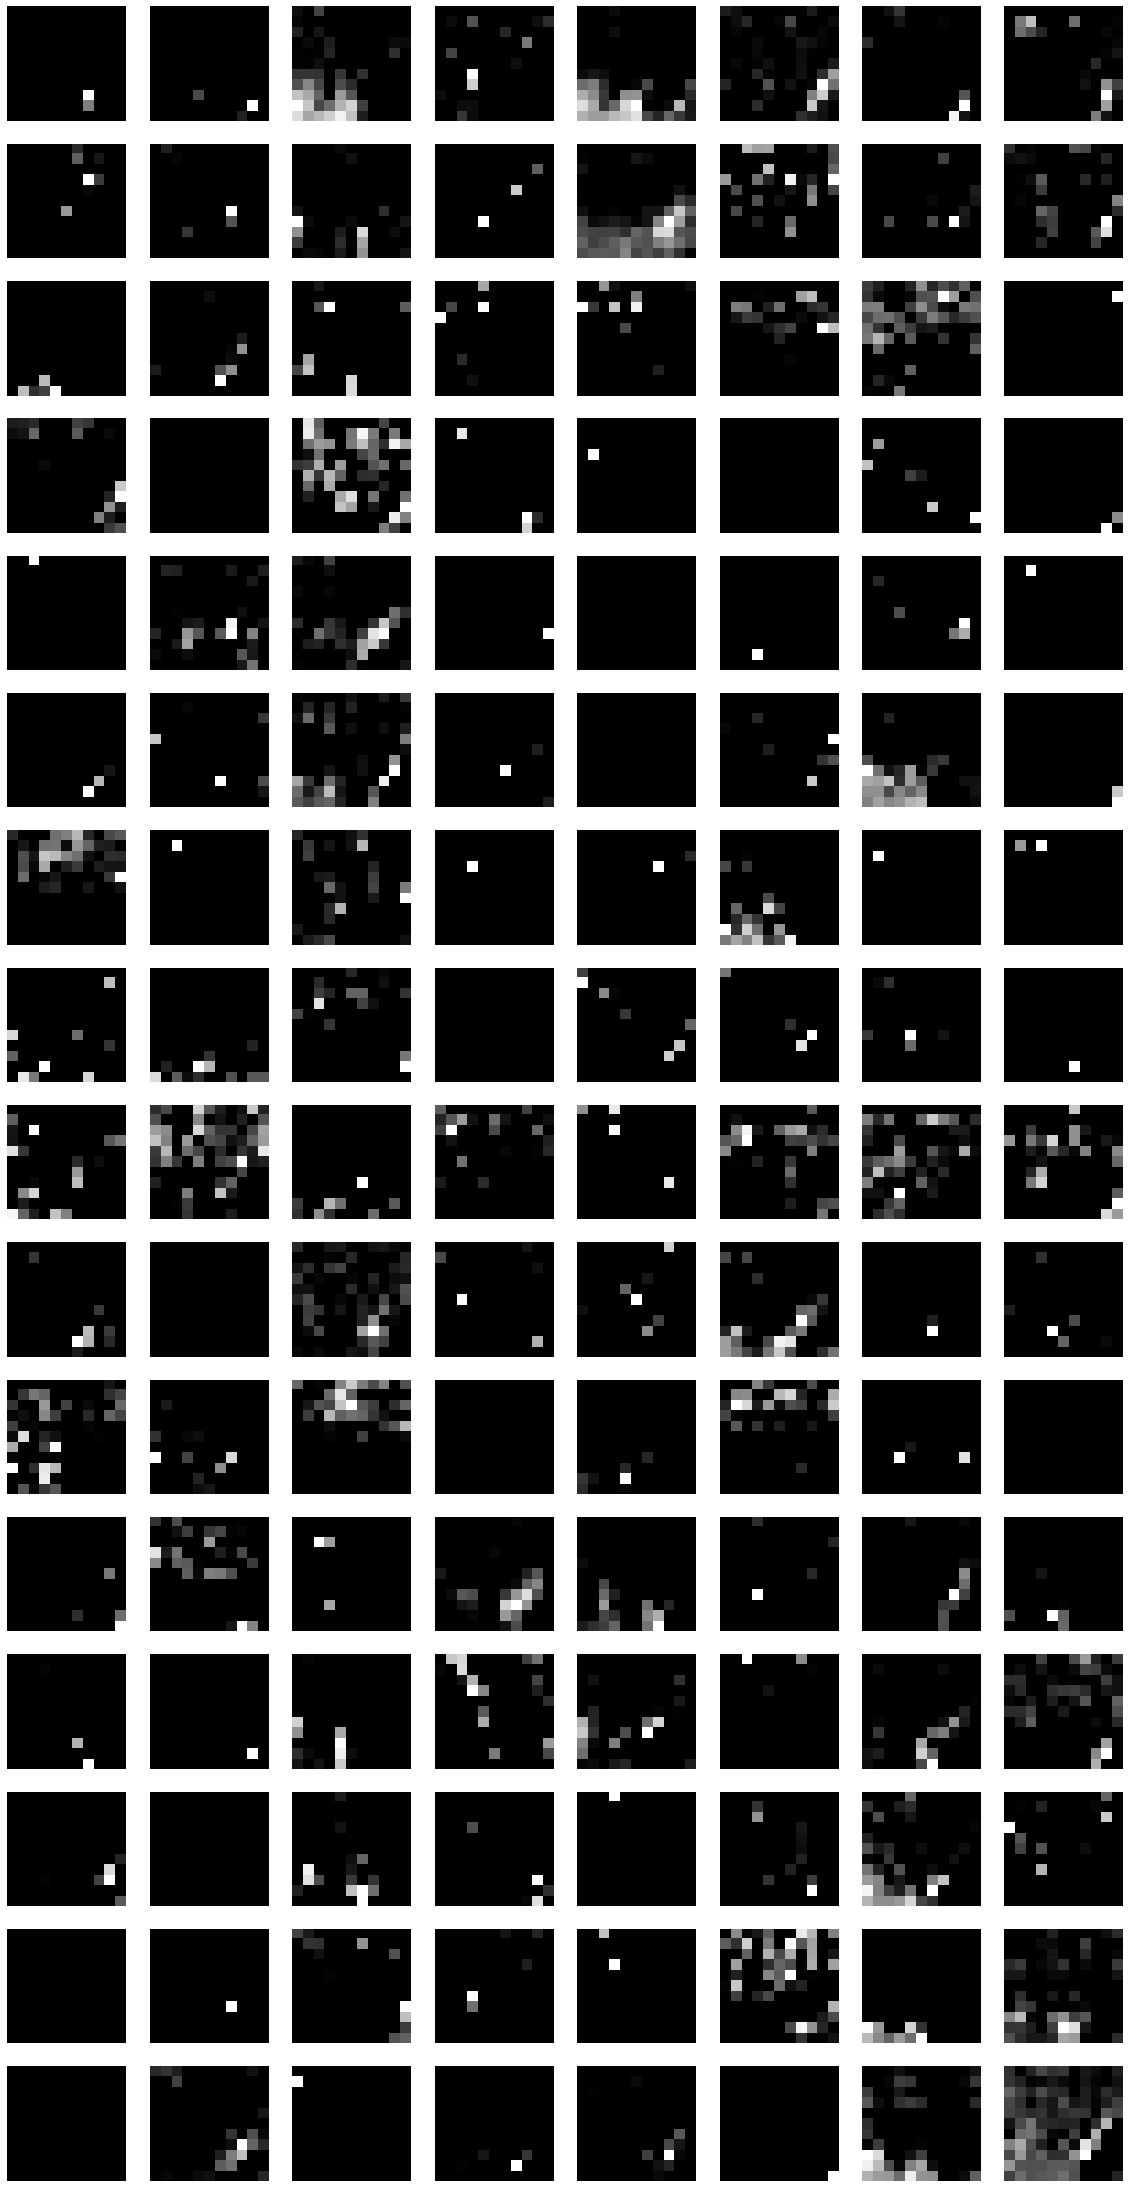

In [51]:
res33 = plot_features(modelo,7,img4)

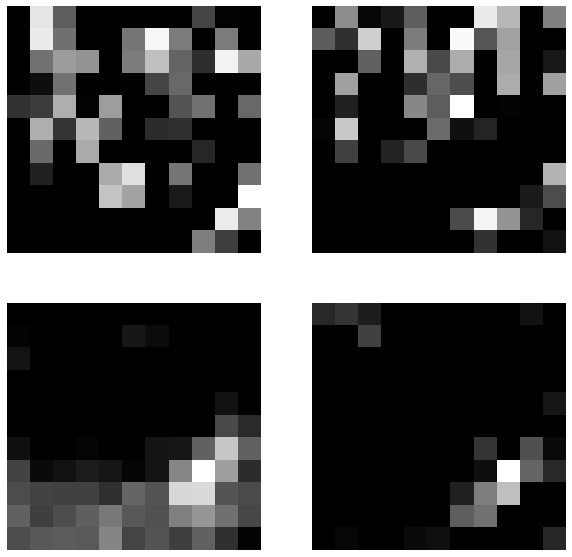

In [52]:
# Continuo enfoque en la grama
# Detalles abstractos pero más específicos del fondo

plot_interesting([26,117,12,121],res33)